In [36]:
import os
import sys
project_path = '..'
sys.path.append(project_path)
from src.data_preprocessing import data_processing

In [24]:
import numpy as np
import torch 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [25]:
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('png')
plt.rcParams['figure.dpi'] = 300 
plt.rcParams['savefig.dpi'] = 300 

In [37]:
df = pd.read_csv('../data/data_hn/hn_02-01/hn_02-01_2024-05-29.csv')
df.shape

(4513, 4)

In [38]:
df = data_processing.filter_data(df, 'y', filter_step= 100)
df.shape

(3850, 4)

In [39]:
df = data_processing.filter_data(df, 'y', filter_step= 1000)
df.shape

(3672, 4)

In [40]:
df = data_processing.filter_data(df, 'y', filter_step=200)
df.shape

(3522, 4)

In [41]:
df['video_record_time'] = pd.to_datetime(df['video_record_time'])
df['y'] = df['y'].astype(float)
df.set_index('video_record_time', inplace=True)

In [42]:
time = df.index
data = df['y'].values
time.shape, data.shape

((3522,), (3522,))

In [32]:
sample_num = df.shape[0]
step = 15 
num_forecast = 1

In [33]:
# create data set
data_set = []
for i in range(sample_num - step - num_forecast):
    data_set.append(df[i: i + step + num_forecast])
data_set = np.array(data_set)
time = time[:data_set.shape[0]]

In [34]:
# split data set
train_set, test_set = data_set[:int(data_set.shape[0] * 0.7)], data_set[int(data_set.shape[0] * 0.7):]
x_train, x_test = train_set[:, :step], test_set[:, :step]
y_train, y_test = train_set[:, step], test_set[:, step]
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2454, 15, 3), (2454, 3), (1052, 15, 3), (1052, 3))

In [43]:
train_lenth, test_lenth = x_train.shape[1], x_test.shape[1]
scaler_x = MinMaxScaler(feature_range= (0,1))
scaler_y = MinMaxScaler(feature_range= (0,1))
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)
y_train = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test = scaler_y.transform(y_test.reshape(-1,1))
x_train.shape, y_train.shape, x_test.shape, y_test.shape

ValueError: could not convert string to float: 'hn_02-01'

In [29]:
# transform to tensor
x_train, y_train = torch.tensor(x_train).float(), torch.tensor(y_train).float()
x_test, y_test = torch.tensor(x_test).float(), torch.tensor(y_test).float()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([1393, 15]),
 torch.Size([1393, 1]),
 torch.Size([598, 15]),
 torch.Size([598, 1]))

In [30]:
# create model
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(step, 5)
        self.fc2 = torch.nn.Linear(5, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()

In [31]:
# create loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

In [32]:
# train model 
epochs = 1000
losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = net(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch {epoch} / {epochs}, Loss: {loss.item()}')

Epoch 0 / 1000, Loss: 0.3628811836242676
Epoch 100 / 1000, Loss: 0.0064764912240207195
Epoch 200 / 1000, Loss: 0.006458002608269453
Epoch 300 / 1000, Loss: 0.006439859978854656
Epoch 400 / 1000, Loss: 0.006420070305466652
Epoch 500 / 1000, Loss: 0.006399684585630894
Epoch 600 / 1000, Loss: 0.006379443686455488
Epoch 700 / 1000, Loss: 0.006359886843711138
Epoch 800 / 1000, Loss: 0.0063414000906050205
Epoch 900 / 1000, Loss: 0.006324261426925659


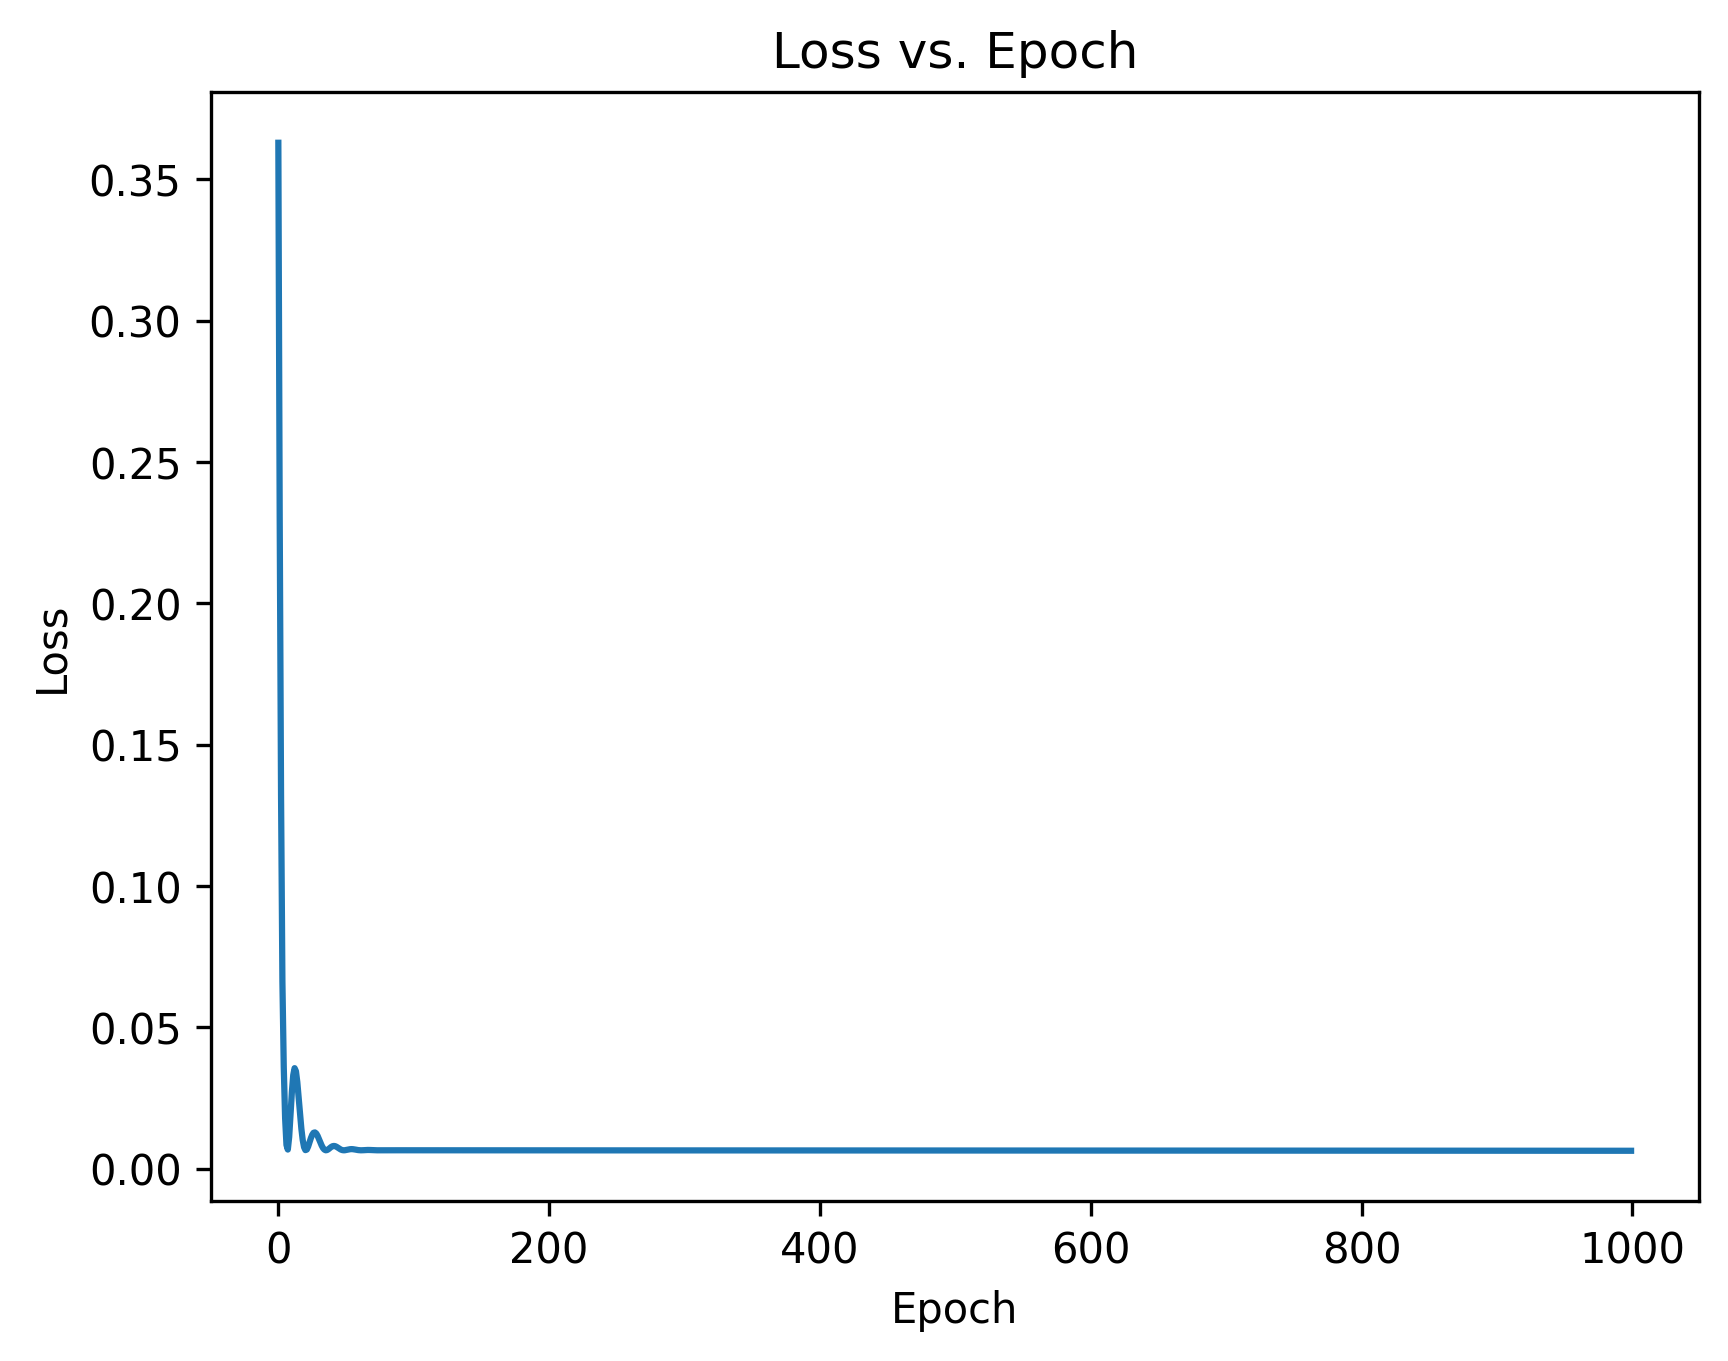

In [33]:
# plot loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.show()

In [34]:
res_train = net(x_train).detach().numpy()
res_test = net(x_test).detach().numpy()
res_train.shape, res_test.shape

((1393, 1), (598, 1))

In [35]:
res_train = scaler_y.inverse_transform(res_train).flatten()
res_test = scaler_y.inverse_transform(res_test).flatten()
y_train_original = scaler_y.inverse_transform(y_train).flatten()
y_test_original = scaler_y.inverse_transform(y_test).flatten()
res_train.shape, res_test.shape, y_train_original.shape, y_test_original.shape

((1393,), (598,), (1393,), (598,))

In [36]:
train_error = mean_squared_error(y_train_original, res_train)
test_error = mean_squared_error(y_test_original, res_test)

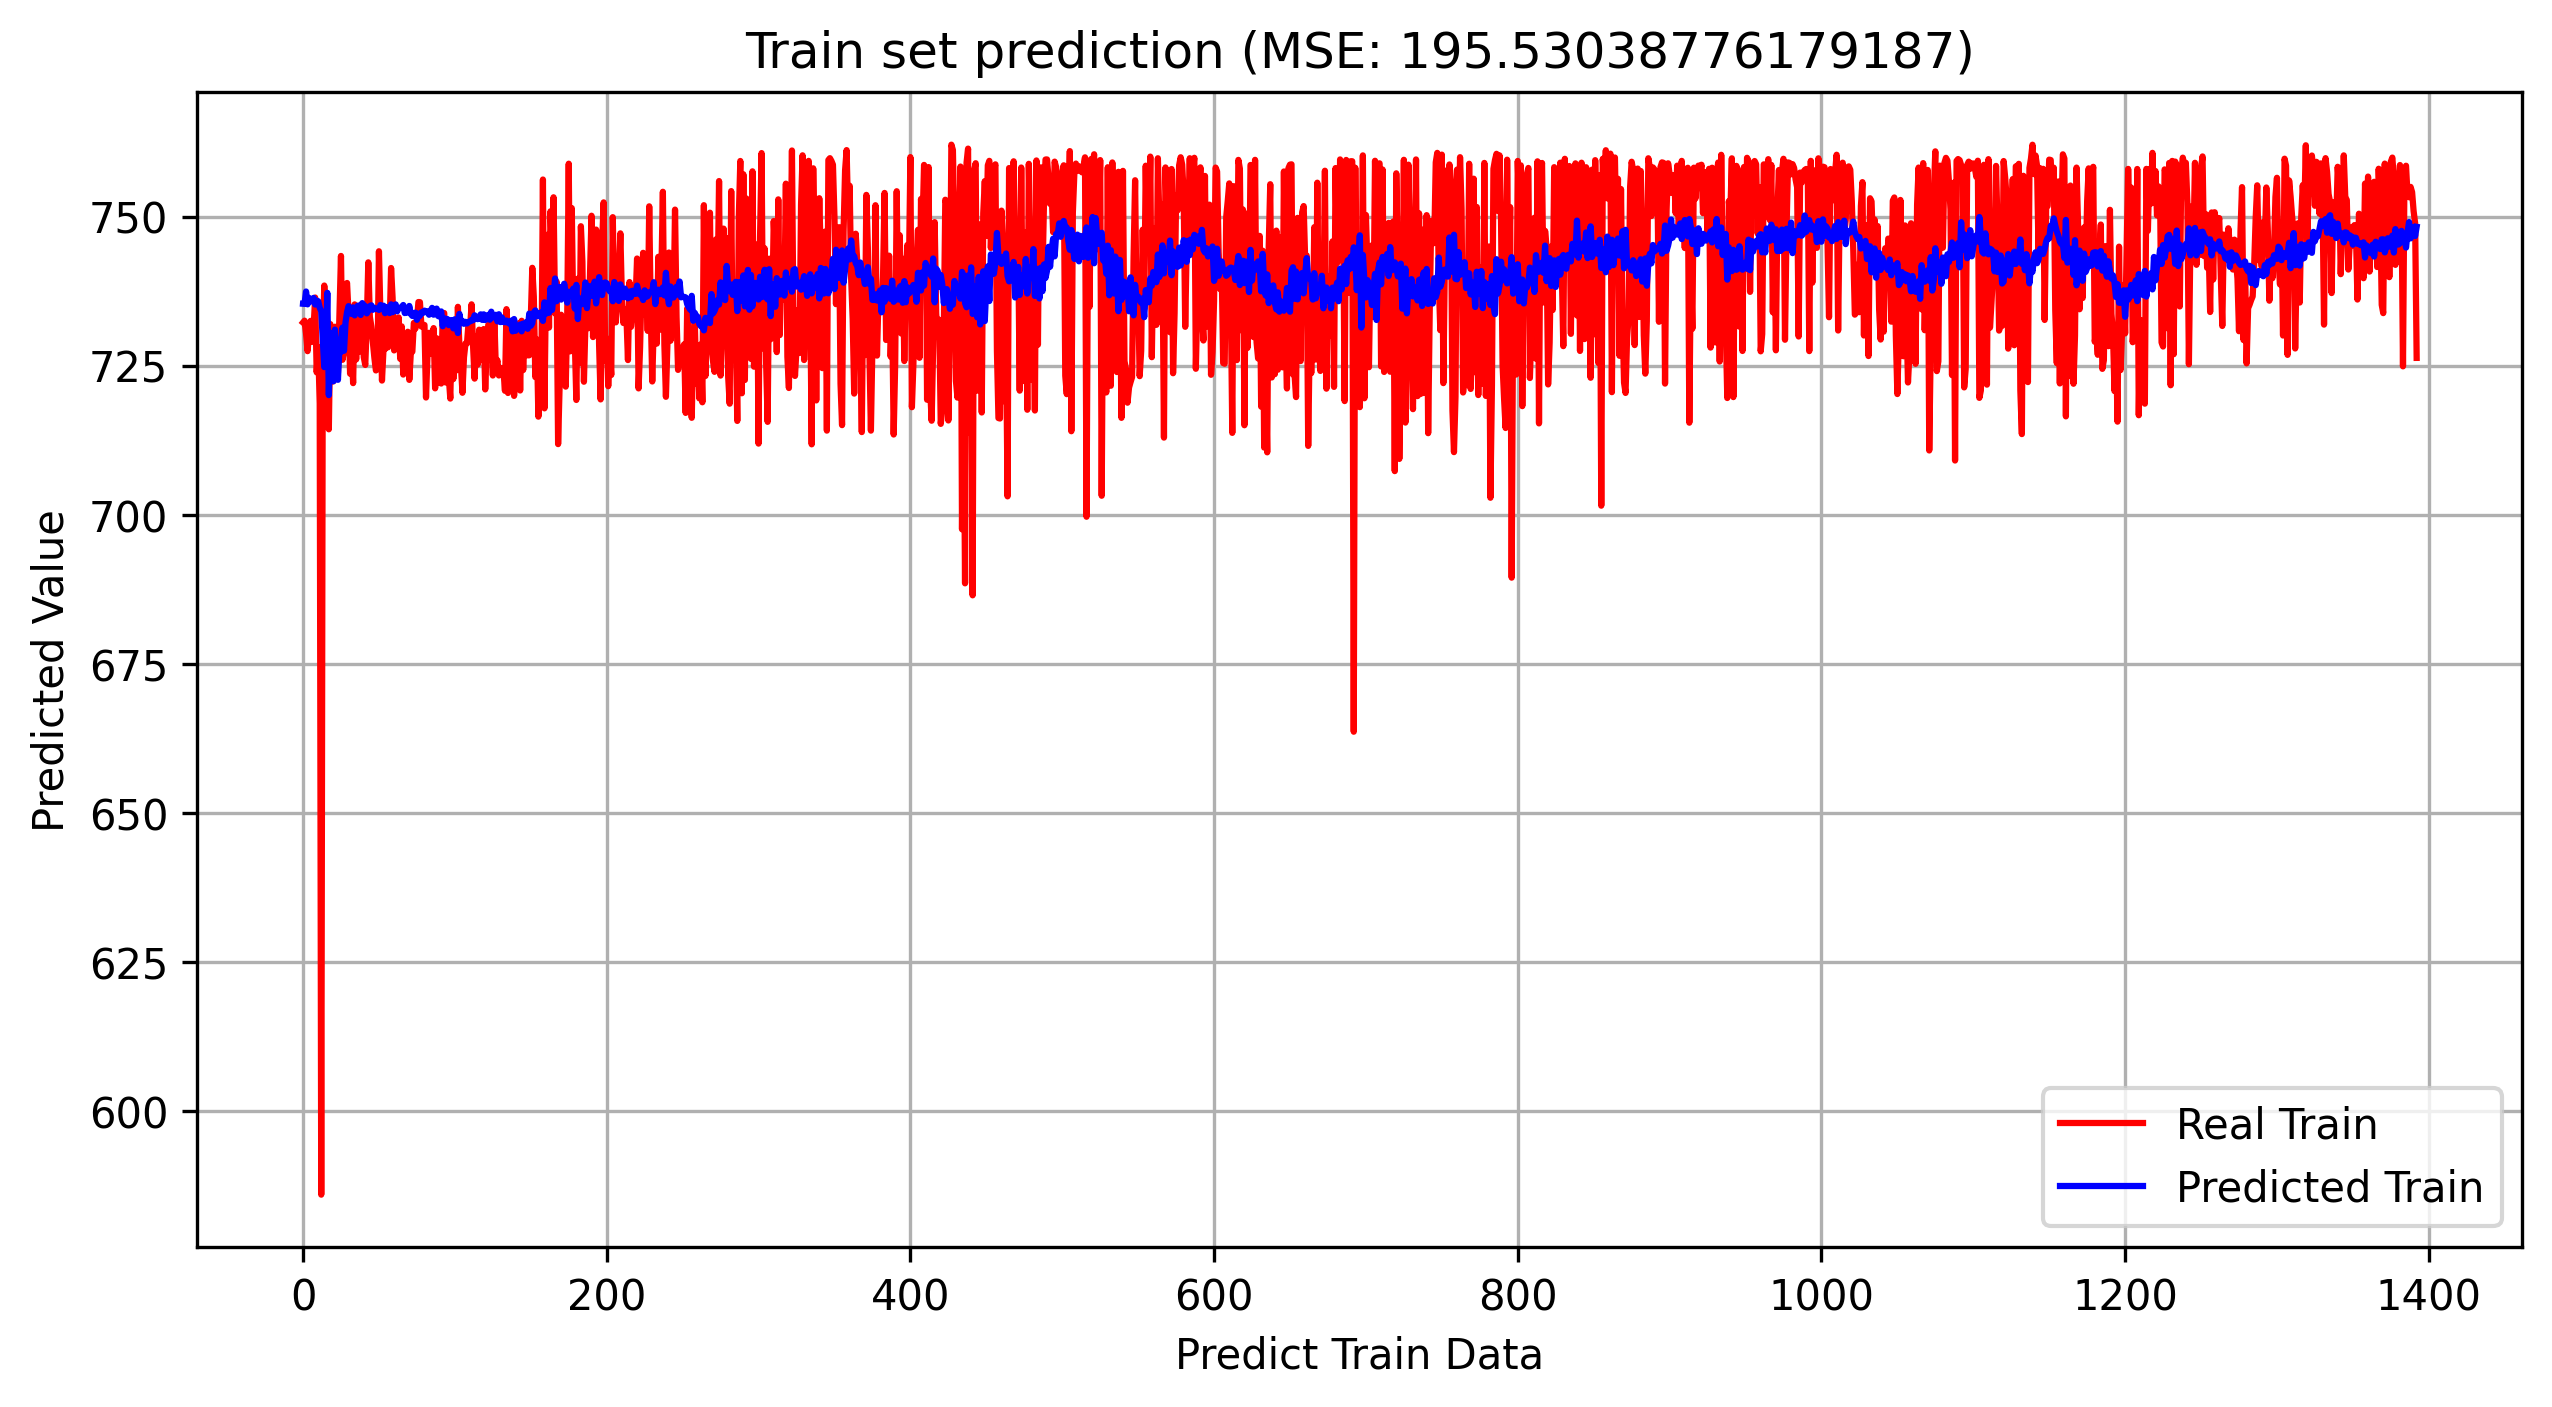

In [37]:
plt.figure(figsize=(10,5))
plt.plot(y_train_original, 'r-', label= 'Real Train')
plt.plot(res_train, 'b-', label = 'Predicted Train')
plt.legend()
plt.xlabel('Predict Train Data')
plt.ylabel('Predicted Value')
plt.title(f'Train set prediction (MSE: {train_error})')
plt.grid()
plt.show()

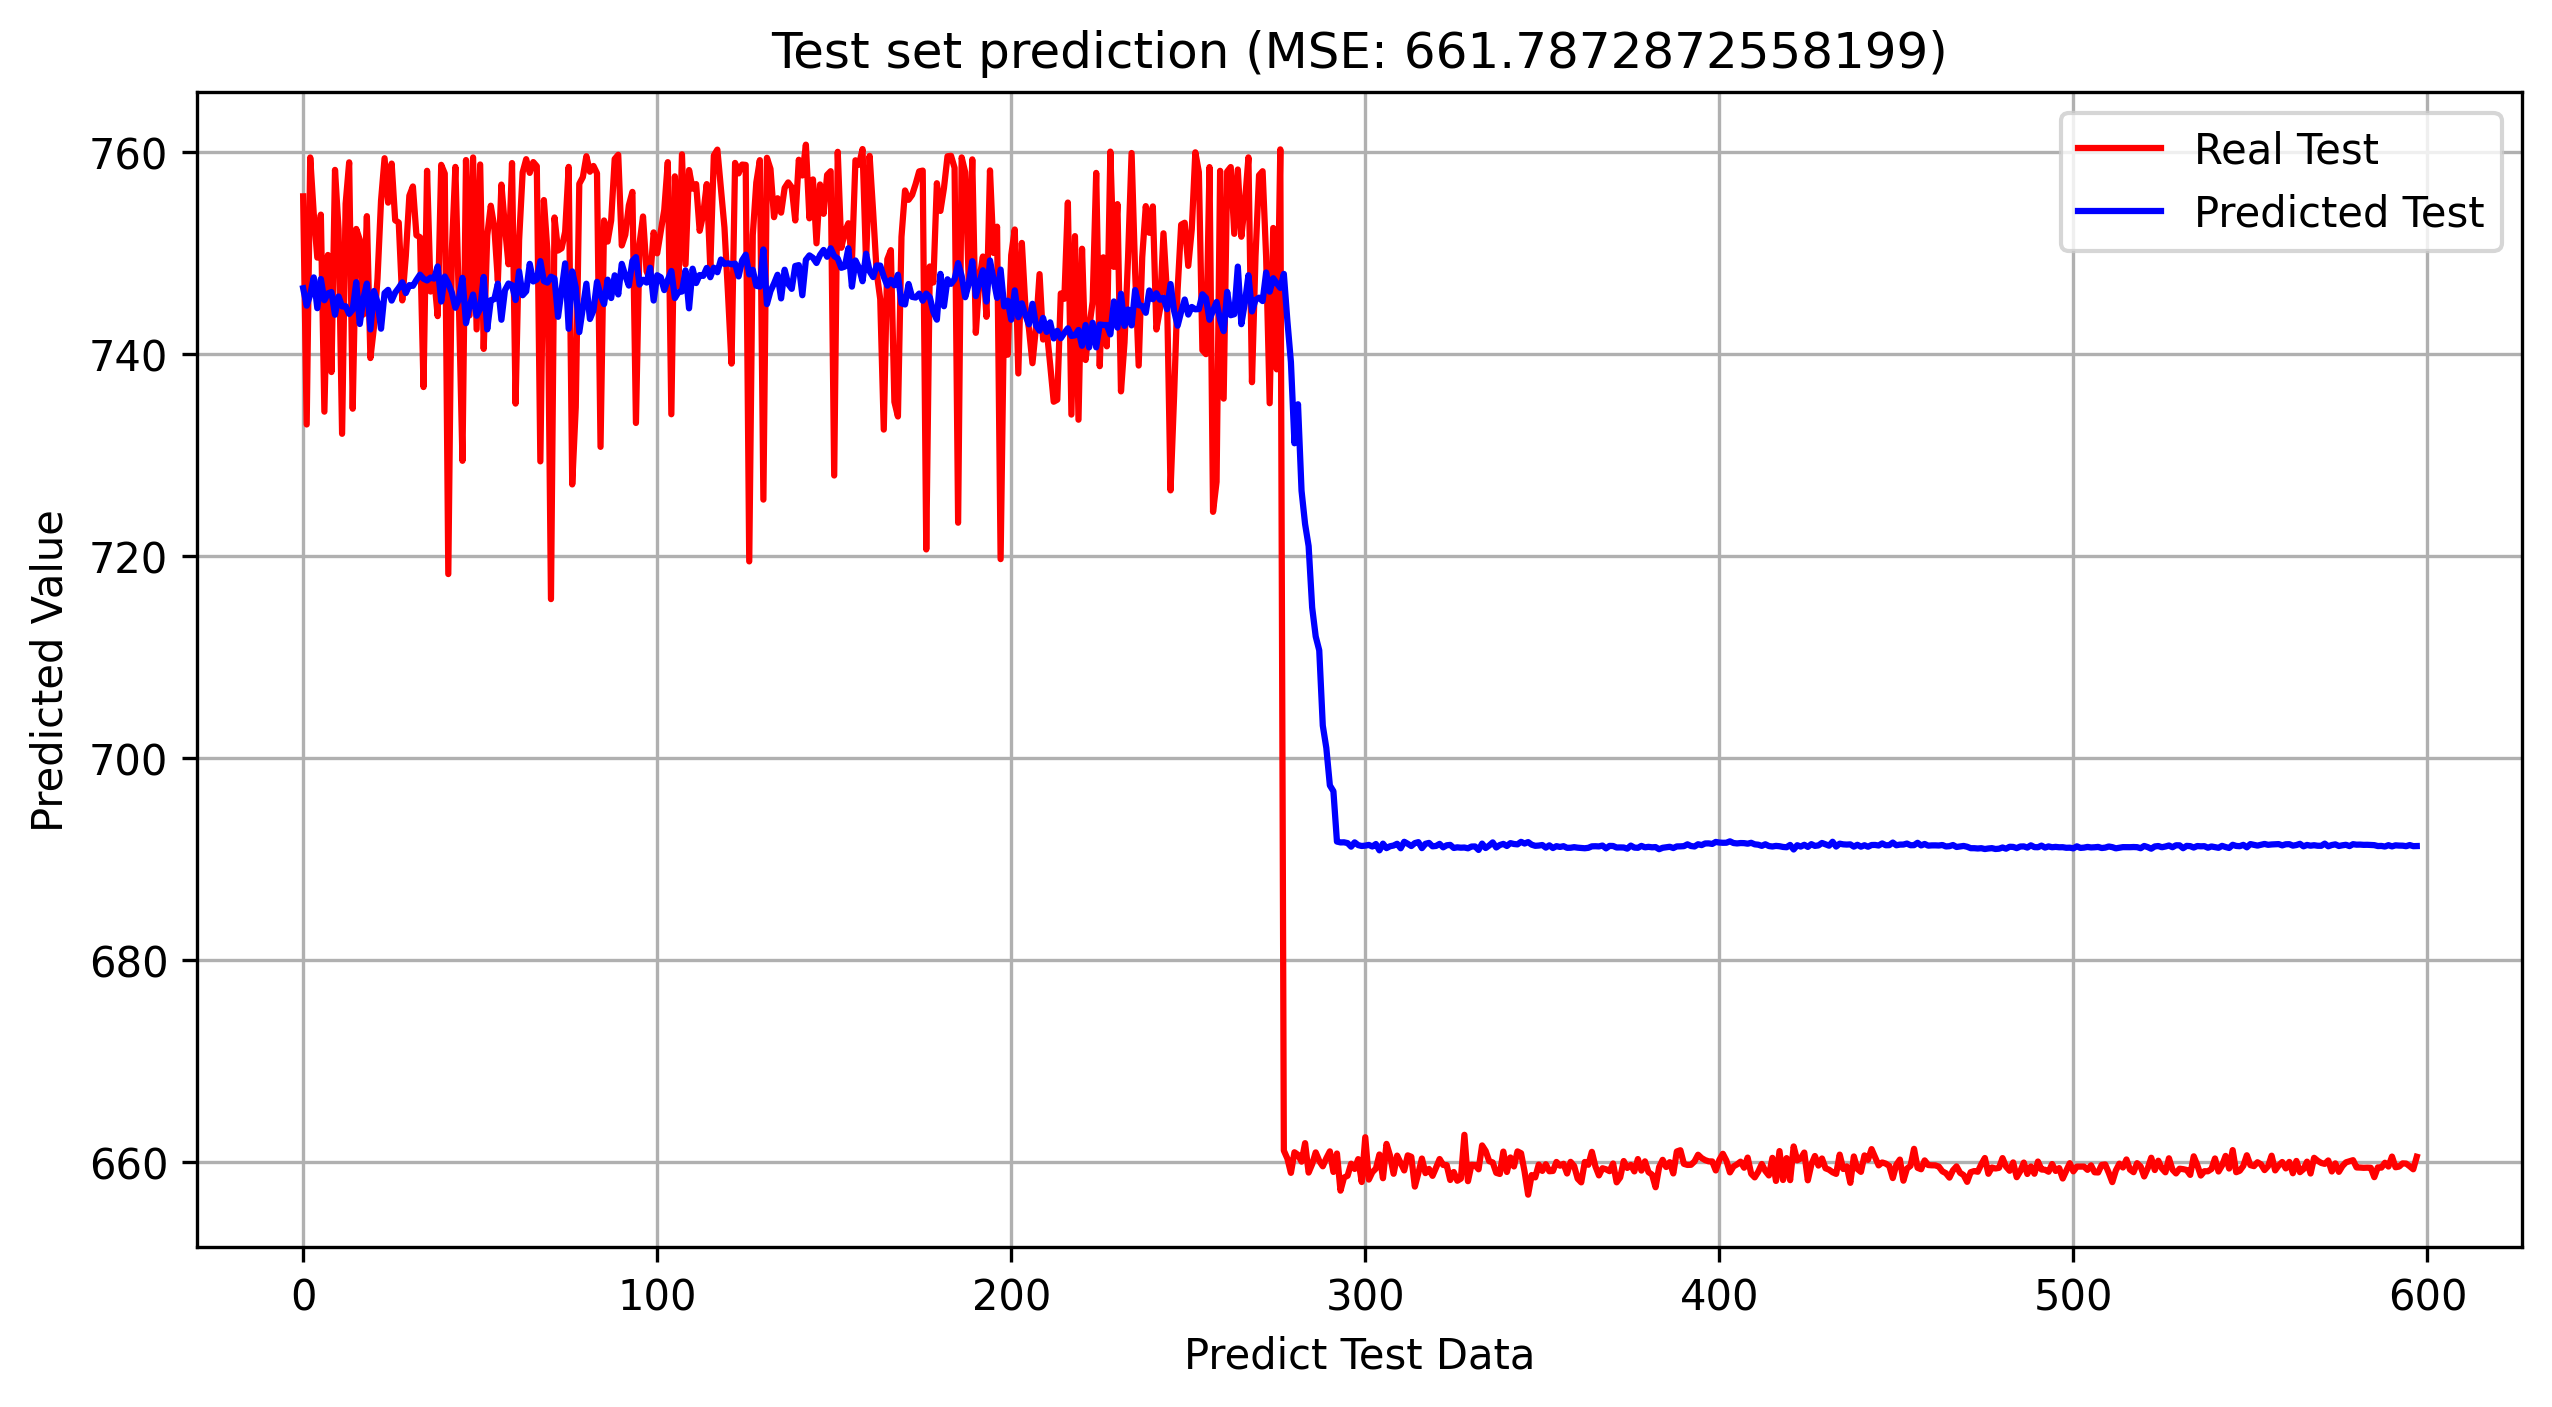

In [38]:
plt.figure(figsize=(10,5))
plt.plot(y_test_original, 'r-', label= 'Real Test')
plt.plot(res_test, 'b-', label = 'Predicted Test')
plt.legend()
plt.xlabel('Predict Test Data')
plt.ylabel('Predicted Value')
plt.title(f'Test set prediction (MSE: {test_error})')
plt.grid()
plt.show()

In [39]:
train_r2 = r2_score(y_train_original, res_train)
test_r2 = r2_score(y_test_original, res_test)
train_mae = mean_absolute_error(y_train_original, res_train)
test_mae = mean_absolute_error(y_test_original, res_test)
train_mbe = np.mean(y_train_original - res_train)
test_mbe = np.mean(y_test_original - res_test)
print(f'Train R2: {train_r2}, Test R2: {test_r2}')
print(f'Train MAE: {train_mae}, Test MAE: {test_mae}')
print(f'Train MBE: {train_mbe}, Test MBE: {test_mbe}')

Train R2: 0.13981167126466676, Test R2: 0.6787265497623852
Train MAE: 11.232591178589974, Test MAE: 21.712898917682637
Train MBE: -0.04363055756711855, Test MBE: -16.11573317913466


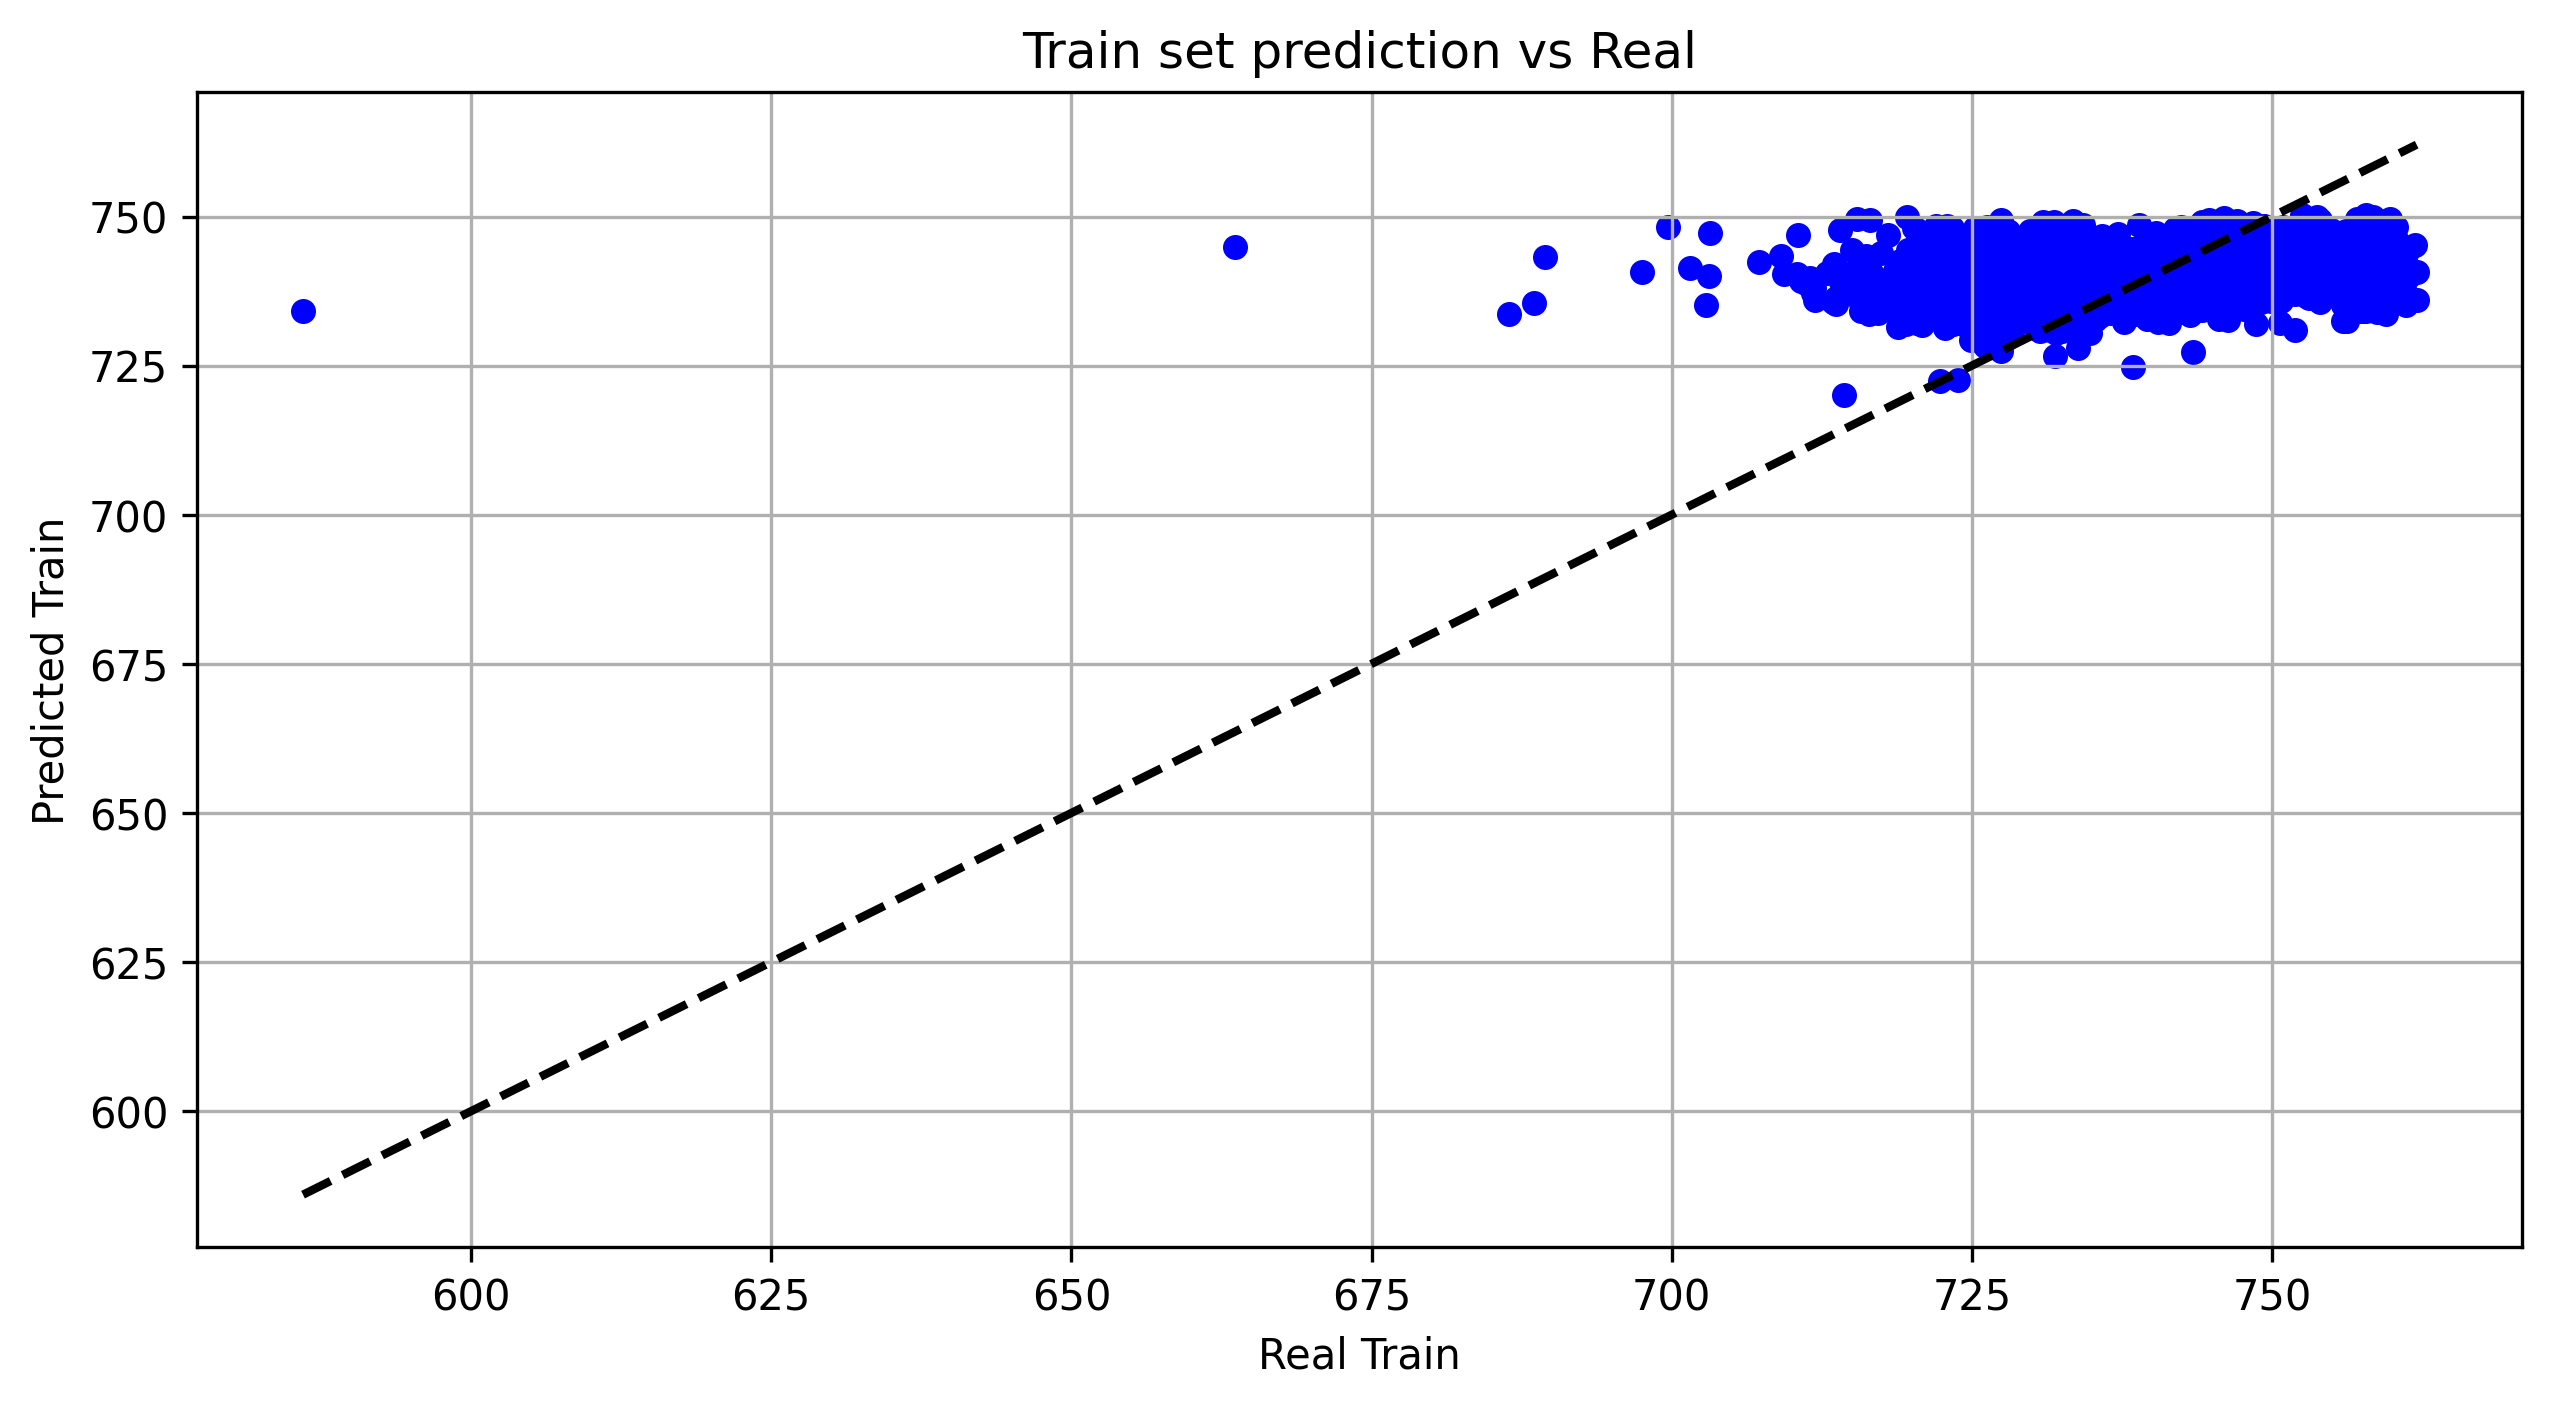

In [40]:
plt.figure(figsize=(10,5))
plt.scatter(y_train_original, res_train, c='b', s=25)
plt.plot([y_train_original.min(), y_train_original.max()], [y_train_original.min(), y_train_original.max()], 'k--', lw=2)
plt.xlabel('Real Train')
plt.ylabel('Predicted Train')
plt.title(f'Train set prediction vs Real')
plt.grid()
plt.show()

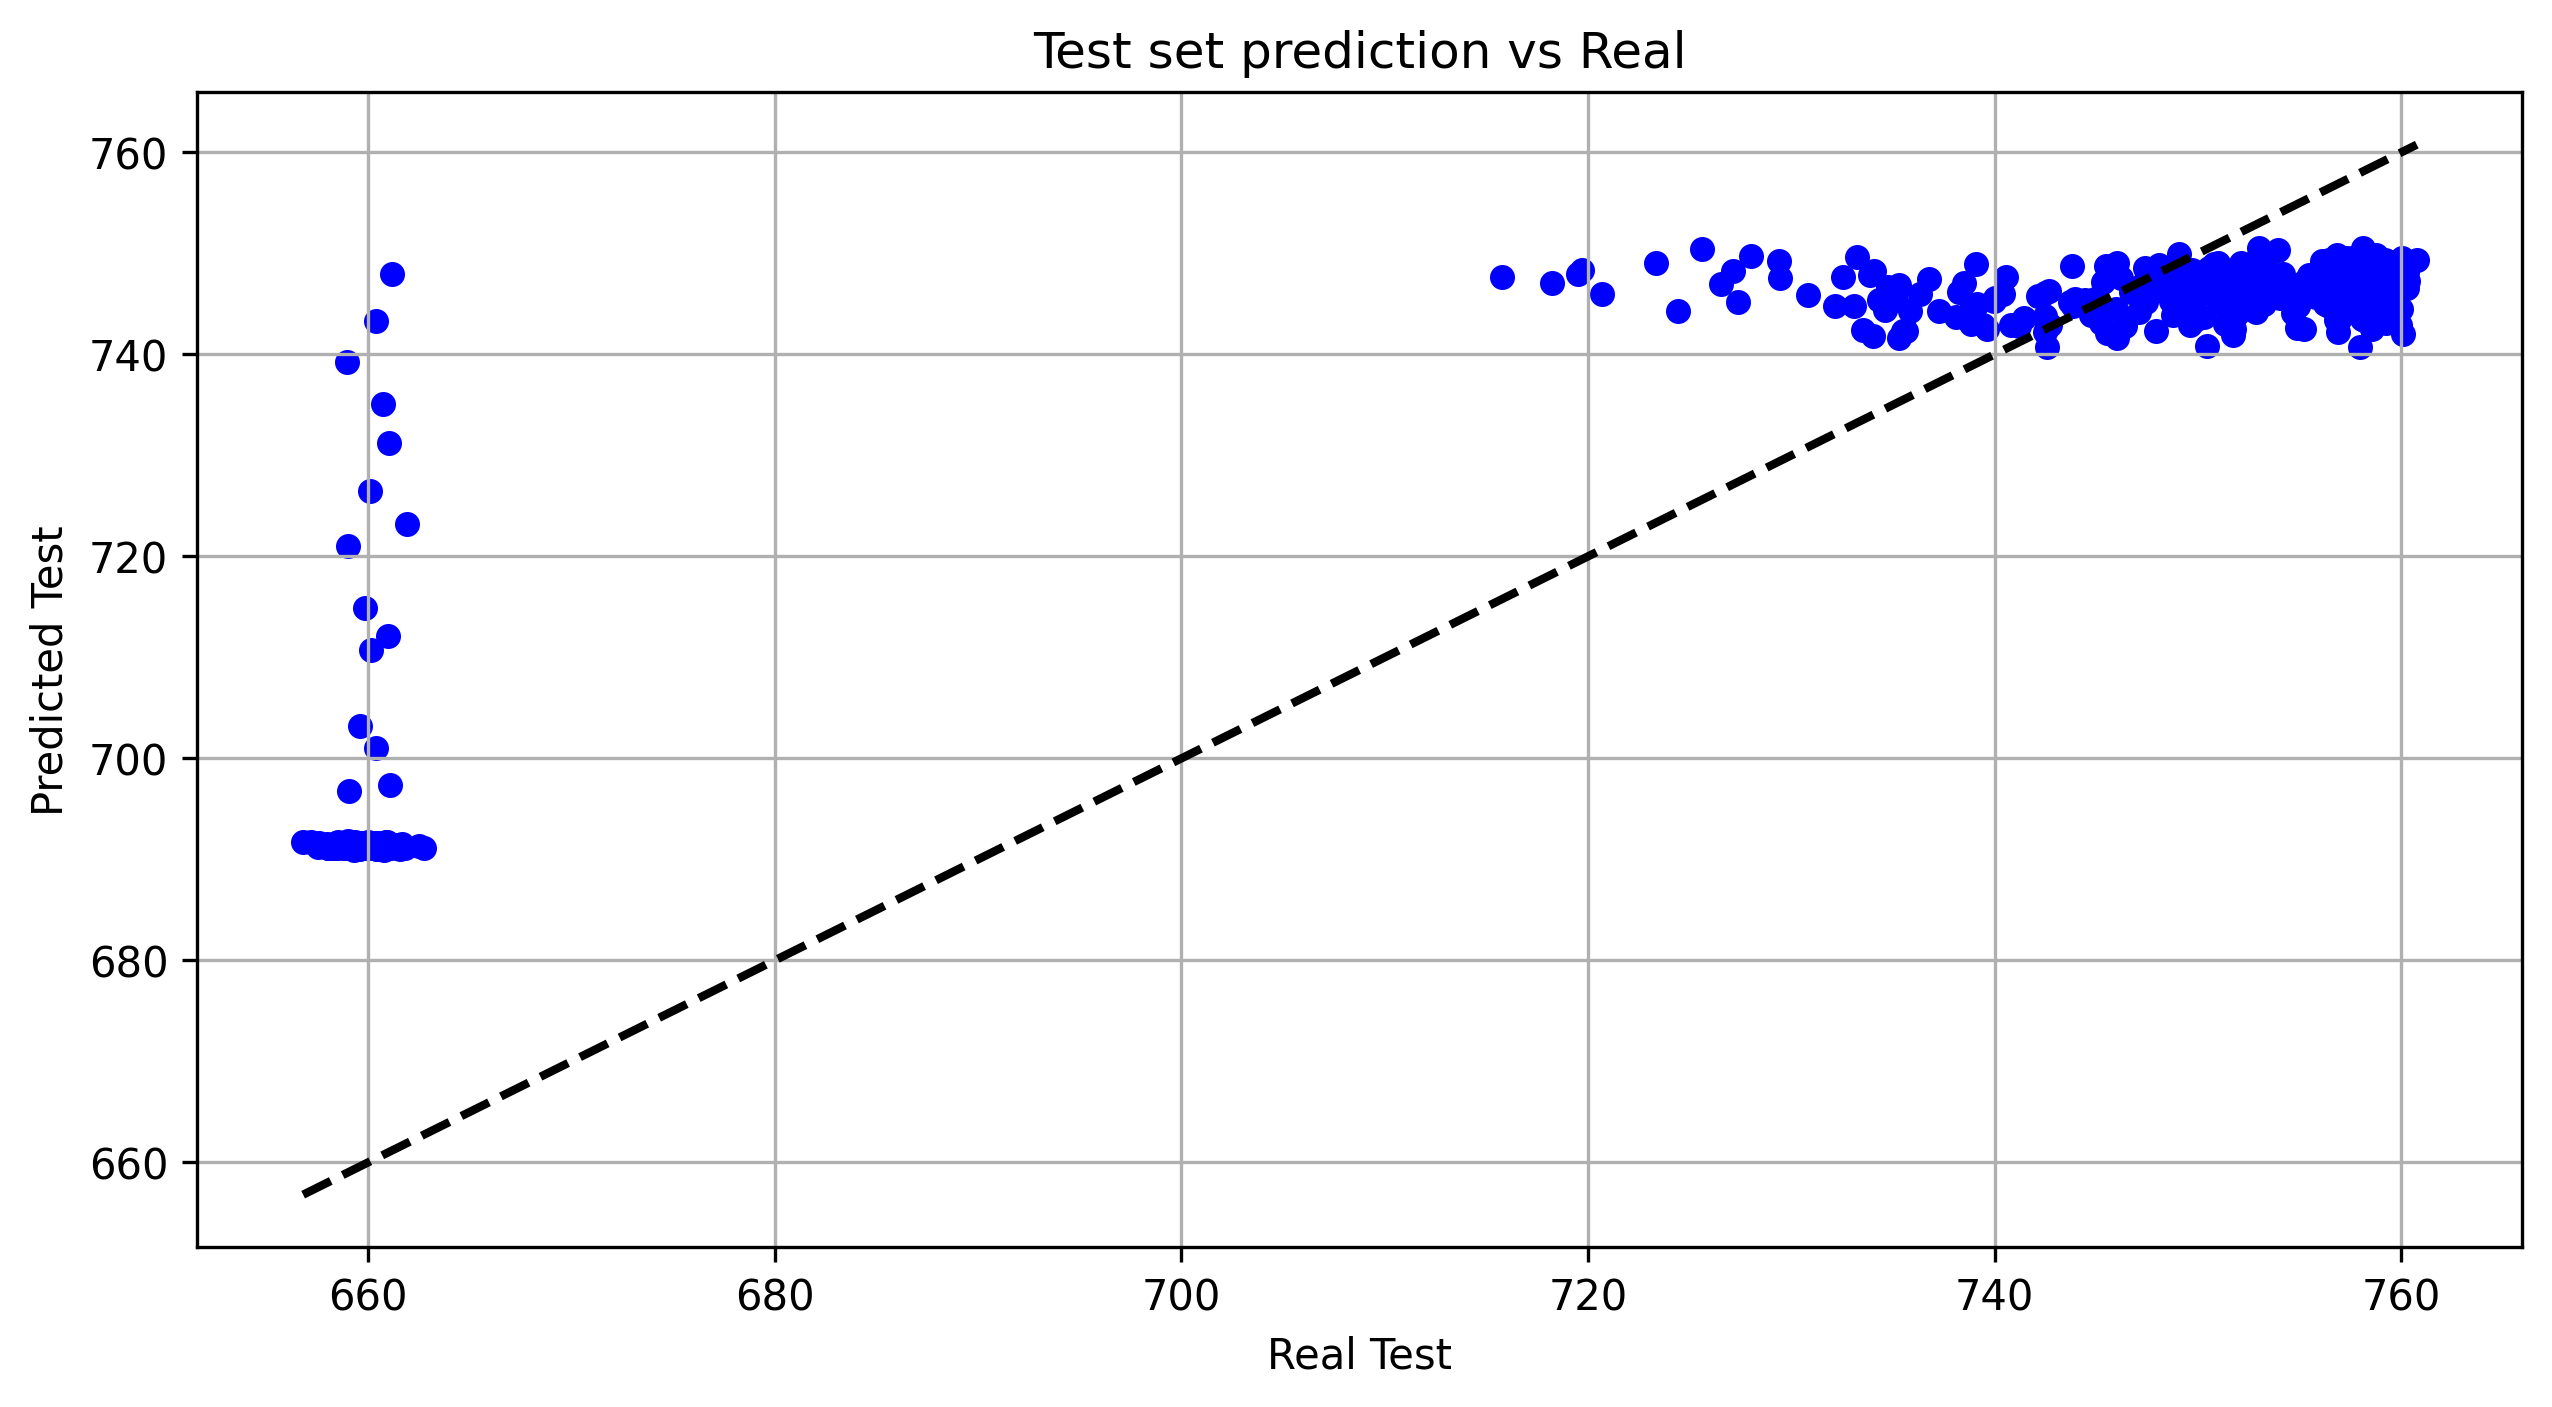

In [41]:
plt.figure(figsize=(10,5))
plt.scatter(y_test_original, res_test, c='b', s=25)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'k--', lw=2)
plt.xlabel('Real Test')
plt.ylabel('Predicted Test')
plt.title(f'Test set prediction vs Real')
plt.grid()
plt.show()